In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/dnn_lambda-1405/dnn_lambda-1405


In [4]:
pip install import-ipynb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.5 MB/s eta 0:00:00


In [1]:
#%cd /content/drive/Shareddrives/dnn_lambda-1405/dnn_lambda-1405

import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
#import sklearn
#from sklearn.model_selection import train_test_split
#import cupy as cp

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
#from torchvision import datasets, transforms
#import torch.optim as optim

import import_ipynb
import dnn_models
from dnn_models import MLP1L, CNN, CNN2D, CNN2DB, CNN2DR

import time

import math
import numpy as np
import cmath as cm
import random
import pickle
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import pickle

import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tabulate import tabulate
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.optim as optim


from datetime import datetime
start_time = datetime.now()

In [2]:
"""
CURR01
--------------
00: no poles
01: 1bt
02: 1bb
03: 1tb
---------------
CURR02
---------------
04: 2bt
05: 1bt, 1bb
06: 1bt, 1tb
---------------
CURR03
---------------
07: 2bb
08: 1bb, 1tb
09: 2tb
---------------
CURR04
---------------
10: 3bt
11: 2bt, 1bb
12: 2bt, 1tb
---------------
CURR05
---------------
13: 1bt, 2bb
14: 1bt, 1bb, 1tb
15: 1bt, 2tb
---------------
CURR06
---------------
16: 3bb
17: 2bb, 1tb
18: 1bb, 2tb
19: 3tb
---------------
"""

'\nCURR01\n--------------\n00: no poles\n01: 1bt\n02: 1bb\n03: 1tb\n---------------\nCURR02\n---------------\n04: 2bt\n05: 1bt, 1bb\n06: 1bt, 1tb\n---------------\nCURR03\n---------------\n07: 2bb\n08: 1bb, 1tb\n09: 2tb\n---------------\nCURR04\n---------------\n10: 3bt\n11: 2bt, 1bb\n12: 2bt, 1tb\n---------------\nCURR05\n---------------\n13: 1bt, 2bb\n14: 1bt, 1bb, 1tb\n15: 1bt, 2tb\n---------------\nCURR06\n---------------\n16: 3bb\n17: 2bb, 1tb\n18: 1bb, 2tb\n19: 3tb\n---------------\n'

In [3]:
class GraphDataset(Dataset):

    def __init__(self, plots, labels, transform=None, transform_label=None):
        self.plots = plots
        self.labels = labels
        self.transform = transform
        self.transform_label = transform_label

    def __getitem__(self, idx):
        label = self.labels[idx]
        plot = self.plots[idx]

        if self.transform:
            plot = self.transform(np.array(plot))

        if self.transform_label:
            label = self.transform_label(np.array(label))

        return plot, label

    def __len__(self):
        return len(self.labels)

In [4]:
def validation_classification(valid_dataloader, model, out, epochs):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    # Initialize lists of losses and accuracies
    pred_value = []
    true_value = []
        
    for epoch in epochs:
        path = f"{out}_snapshot/epoch{epoch:06d}/MLP1L.pt"
        accuracy = pickle.load(open(os.path.join(f"{out}_snapshot/epoch{epoch:06d}","testing_accu1.pkl"),"rb"))
        accuracy = accuracy[-1]
        #validation_loss1 = []
        #validation_accu1 = []


        #Load the model and the optimizer of the previous run
        saved_model = torch.load(path, weights_only=True, map_location=torch.device(device))
        model.load_state_dict(saved_model['model_state_dict'])
        #optimizer.load_state_dict(saved_model['optimizer_state_dict'])

        model.to(device)

        model.eval()
        size = len(valid_dataloader.dataset)
        num_batches = len(valid_dataloader)
        valid_loss, valid_accu = 0., 0.

        #Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
        # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
        with torch.no_grad():
            for X, y in valid_dataloader:
                pred = model(X)
                #valid_loss += loss_fn(pred, y).item()
                #valid_accu += (pred.argmax(1) == y).type(torch.float).sum().item()
                pred_value.append(torch.IntTensor.item(pred.argmax(1)))
                true_value.append(torch.IntTensor.item(y))

        #validation_accu1.append(valid_accu/size)
        #validation_loss1.append(valid_loss/num_batches)
        #pred_value = np.array(pred_value)
        #true_value = np.array(true_value)
    return pred_value, true_value, accuracy#, confusion_matrix

    #print(f"Test Error: \n Accuracy: {(100*test_accu):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [5]:
def validation_regression(valid_dataloader, model, out):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    # Initialize lists of losses and accuracies

    path = f"{out}/MLP1L.pt"
    loss = pickle.load(open(os.path.join(out,"testing_loss1.pkl"),"rb"))
    loss = loss[-1]
    pred_value = []
    true_value = []
    validation_loss1 = []
    #validation_accu1 = []
    loss_fn = nn.MSELoss()

    #Load the model and the optimizer of the previous run
    saved_model = torch.load(path, weights_only=True)
    model.load_state_dict(saved_model['model_state_dict'])
    #optimizer.load_state_dict(saved_model['optimizer_state_dict'])

    model.to(device)

    model.eval()
    size = len(valid_dataloader.dataset)
    num_batches = len(valid_dataloader)
    valid_loss, valid_accu = 0., 0.

    #Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in valid_dataloader:
            pred = torch.round(model(X))
            valid_loss += loss_fn(pred, y).item()
            #valid_accu += (pred.argmax(1) == y).type(torch.float).sum().item()
            pred = pred.long()
            pred_value.append(y)
            true_value.append(pred)

    #validation_accu1.append(valid_accu/size)
    validation_loss1.append(valid_loss/num_batches)

    validation_loss1 = np.asarray(validation_loss1)
    #pred_value = np.array(pred_value)
    #true_value = np.array(true_value)
    return pred_value, true_value, validation_loss1 #pred_value, true_value, accuracy#, confusion_matrix

    #print(f"Test Error: \n Accuracy: {(100*test_accu):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [6]:
model = CNN2D()
#model = CNN2D()

# Make device agnostic code
device = "cpu"
print(device)

#device = "cpu"
#print(device)
model=model.to(device)
print(model)

cpu
CNN2D(
  (conv1): Conv2d(1, 4, kernel_size=(2, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(2, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=120, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=4, bias=True)
  (relu): ReLU()
)


In [19]:
curr = 6
ticks = [1, 16, 17, 18]
#directory = f"250209_lambda-1405_full_curriculum{curr:02d}"
directory = f"250218_lambda-1405_full_curriculum{curr:02d}"
valid_plots = pickle.load(open(os.path.join(directory, f'valid_plots_curr{curr:02d}.pkl'), 'rb'))
valid_plots = torch.from_numpy(valid_plots).type(torch.float).to(device)
valid_labels = pickle.load(open(os.path.join(directory, f'valid_labels_curr{curr:02d}.pkl'), 'rb'))
valid_labels = torch.from_numpy(valid_labels).type(torch.long).to(device)
#train_dataset = GraphDataset(train_plots, train_labels, transform=None)
valid_dataset = GraphDataset(valid_plots, valid_labels, transform=None)

print(len(valid_labels))

batch_size = 1

#train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
#del valid_dataset, valid_labels, valid_plots, directory, curriculum

out = f"250218_lambda_curriculum{curr:02d}_full"
training_loss1 = pickle.load(open(os.path.join(out,"training_loss1.pkl"),"rb"))
testing_loss1 = pickle.load(open(os.path.join(out,"testing_loss1.pkl"),"rb"))
print(len(testing_loss1))
sorted_epochs = np.argsort(testing_loss1)+1
lst = []
for epoch in sorted_epochs:
    if epoch%1==0:
        lst.append(epoch)
epochs = np.array(lst)[:5]
print(epochs)

optimizer = "Adam"
pred_value1, true_value1, accu1 = validation_classification(valid_dataloader, model,
                                                            f"250218_lambda_curriculum{curr:02d}", epochs)

loss_fn = nn.CrossEntropyLoss()

8000
500
[248 302 372 220 327]


FileNotFoundError: [Errno 2] No such file or directory: '250218_lambda_curriculum06_snapshot/epoch000248/testing_accu1.pkl'

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10000
           1       0.89      0.84      0.86     10000
           2       0.86      0.90      0.88     10000
           3       0.98      0.99      0.98     10000

    accuracy                           0.93     40000
   macro avg       0.93      0.93      0.93     40000
weighted avg       0.93      0.93      0.93     40000



<>:43: SyntaxWarning: invalid escape sequence '\S'
<>:43: SyntaxWarning: invalid escape sequence '\S'
/var/folders/c5/0thgw44d7rdfzbt06_p9nlbr0000gn/T/ipykernel_62904/2874625436.py:43: SyntaxWarning: invalid escape sequence '\S'
  plt.title(f"$\Sigma^+\pi^-$; Stage: {curr}")


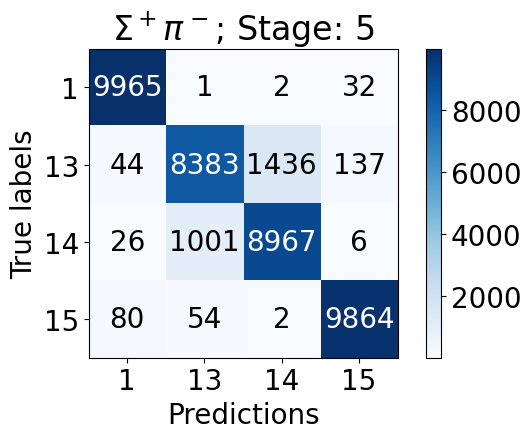

In [18]:
plt.rcParams.update({'font.size': 20})
#labels0 = [[0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1], [2, 0, 0], [1, 1, 0], [1, 0, 1],
#         [0, 2, 0], [0, 1, 1], [0, 0, 2], [2, 1, 0], [1, 2, 0], [1, 1, 1]]
#labels0 = torch.tensor(labels0)
#pred_value = []
#true_value = []

#for i in range(len(true_value1)):
#    pred_value.append(pred_value1[i])
#    true_value.append(true_value1[i])


#print(true_value)
labels = np.unique(pred_value1)

cm3 = confusion_matrix(true_value1, pred_value1)
outputs = 4
im3 = plt.imshow(cm3)
labels1=np.unique(true_value1) #range(0,outputs)

# Show all ticks and label them with the respective list entries
plt.xticks(labels, ticks, )
plt.yticks(labels, ticks)

# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")

#Loop over data dimensions and create text annotations.
for i in range(len(labels)):
    for j in range(len(labels)):
        if i == j:
            text = plt.text(j, i, cm3[i, j],
                       ha="center", va="center", color="w")
        else: 
            text = plt.text(j, i, cm3[i, j],
                       ha="center", va="center", color="black")

#cbar = ax[1,1].figure.colorbar(im4, ax=ax[1,1])
#cbar.ax.set_ylabel(labels, rotation=-90, va="bottom")


plt.title(f"$\Sigma^+\pi^-$; Stage: {curr}")
#fig.set_figheight(20)
#fig.set_figwidth(20)
plt.xlabel("Predictions")
plt.ylabel("True labels")
plt.tight_layout()
plt.set_cmap('Blues')

#cbar_ax = fig.add_axes([0.95, 0.25, 0.02, 0.4])
plt.colorbar()
plt.savefig(f'250218_lambda_curr{curr:02d}-confusion-matrix')
#cm1 = confusion_matrix(true_value3, pred_value3)
print(classification_report(true_value1, pred_value1))

In [ ]:
i = np.random.randint(1, 1800)
print(pred_value1[i], true_value1[i])

              precision    recall  f1-score   support

           0       0.75      0.79      0.76       205
           1       0.77      0.86      0.81       205
           2       0.46      0.64      0.53       205
           3       0.49      0.80      0.61       205
           4       0.88      0.88      0.88       205
           5       0.79      0.62      0.69       205
           6       0.76      0.51      0.61       205
           7       0.70      0.94      0.80       205
           8       0.72      0.79      0.75       205
           9       0.69      0.43      0.53       204
          10       0.92      0.84      0.88       205
          11       0.84      0.53      0.65       204
          12       0.75      0.54      0.63       205

    accuracy                           0.71      2663
   macro avg       0.73      0.71      0.70      2663
weighted avg       0.73      0.71      0.70      2663



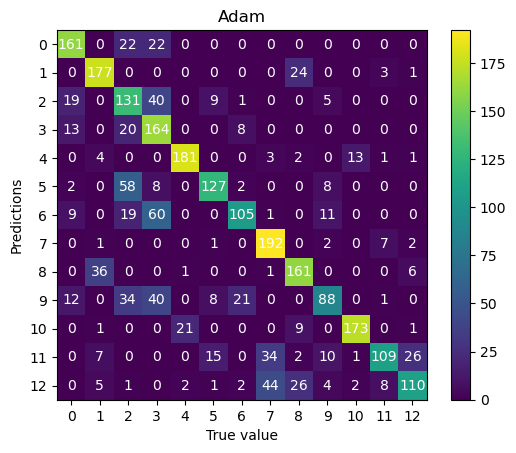

In [ ]:
labels = np.unique(true_value2)
cm3 = confusion_matrix(true_value2, pred_value2)

outputs = 13

im3 = plt.imshow(cm3)
labels1=range(0,outputs)

# Show all ticks and label them with the respective list entries
plt.xticks(labels)
plt.yticks(labels)

# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")

#Loop over data dimensions and create text annotations.
for i in range(len(labels)):
    for j in range(len(labels)):
        text = plt.text(j, i, cm3[i, j],
                       ha="center", va="center", color="w")

#cbar = ax[1,1].figure.colorbar(im4, ax=ax[1,1])
#cbar.ax.set_ylabel(labels, rotation=-90, va="bottom")


plt.title(f"{optimizer}")
#fig.set_figheight(20)
#fig.set_figwidth(20)
plt.xlabel("True value")
plt.ylabel("Predictions")
#fig.tight_layout()

#cbar_ax = fig.add_axes([0.95, 0.25, 0.02, 0.4])
plt.colorbar()
plt.savefig(f'lambda-1405-confusion-matrix')
#cm1 = confusion_matrix(true_value3, pred_value3)
print(classification_report(true_value2, pred_value2))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       100
         1.0       0.65      0.76      0.70       300
         2.0       0.62      0.65      0.64       300
         3.0       0.74      0.61      0.67       300
         4.0       0.88      0.84      0.86       300

    accuracy                           0.74      1300
   macro avg       0.78      0.77      0.77      1300
weighted avg       0.74      0.74      0.74      1300



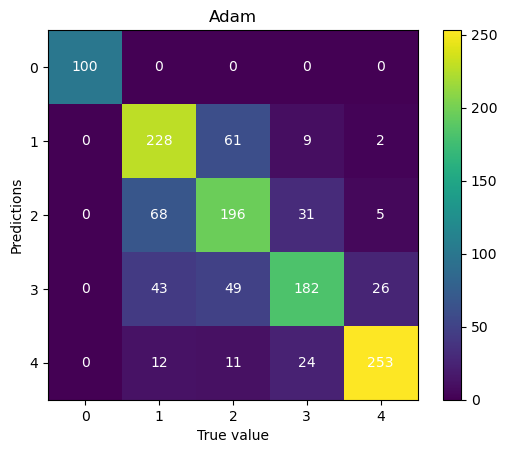

In [ ]:
labels = np.unique(true_value4)
cm3 = confusion_matrix(true_value4, pred_value4)

im3 = plt.imshow(cm3)
labels1=range(0,10)

# Show all ticks and label them with the respective list entries
plt.xticks(labels)
plt.yticks(labels)

# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")

#Loop over data dimensions and create text annotations.
for i in range(len(labels)):
    for j in range(len(labels)):
        text = plt.text(j, i, cm3[i, j],
                       ha="center", va="center", color="w")

#cbar = ax[1,1].figure.colorbar(im4, ax=ax[1,1])
#cbar.ax.set_ylabel(labels, rotation=-90, va="bottom")


plt.title(f"{optimizer}")
#fig.set_figheight(10)
#fig.set_figwidth(20)
plt.xlabel("True value")
plt.ylabel("Predictions")
#fig.tight_layout()

#cbar_ax = fig.add_axes([0.95, 0.25, 0.02, 0.4])
plt.colorbar()
plt.savefig(f'CNN2D-5_Adam-1N_24-12-29_confusion', bbox_inches='tight')
#cm1 = confusion_matrix(true_value3, pred_value3)
print(classification_report(true_value4, pred_value4))

In [ ]:
curriculum=15
directory = f"curriculum{curriculum:02d}_training"
valid_plots = pickle.load(open(os.path.join(directory, f'valid_plots_curr{curriculum:02d}.pkl'), 'rb'))
valid_plots = torch.from_numpy(valid_plots).type(torch.float).to(device)
valid_labels = pickle.load(open(os.path.join(directory, f'valid_labels_curr{curriculum:02d}.pkl'), 'rb'))
valid_labels = torch.from_numpy(valid_labels).type(torch.float).to(device)
#train_dataset = GraphDataset(train_plots, train_labels, transform=None)
valid_dataset = GraphDataset(valid_plots, valid_labels, transform=None)

batch_size = 1

#train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader5 = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
del valid_dataset, valid_labels, valid_plots, directory, curriculum

In [ ]:
model = CNN2DR()
out = "CNN2DR-5_Adam-0_24-12-29_full"
loss_fn = nn.MSELoss()
validation_regression(valid_dataloader5, model, out)

array([0.11274185])

In [ ]:
"""
curriculum = 1
directory = f"curriculum{curriculum:02d}_training"
valid_plots = pickle.load(open(os.path.join(directory, f'valid_plots_curr{curriculum:02d}.pkl'), 'rb'))
valid_plots = torch.from_numpy(valid_plots).type(torch.float).to(device)
valid_labels = pickle.load(open(os.path.join(directory, f'valid_labels_curr{curriculum:02d}.pkl'), 'rb'))
valid_labels = torch.from_numpy(valid_labels).type(torch.long).to(device)
#train_dataset = GraphDataset(train_plots, train_labels, transform=None)
valid_dataset = GraphDataset(valid_plots, valid_labels, transform=None)

batch_size = 1

#train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader1 = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
del valid_dataset, valid_labels, valid_plots, directory, curriculum

curriculum = 2
directory = f"curriculum{curriculum:02d}_training"
valid_plots = pickle.load(open(os.path.join(directory, f'valid_plots_curr{curriculum:02d}.pkl'), 'rb'))
valid_plots = torch.from_numpy(valid_plots).type(torch.float).to(device)
valid_labels = pickle.load(open(os.path.join(directory, f'valid_labels_curr{curriculum:02d}.pkl'), 'rb'))
valid_labels = torch.from_numpy(valid_labels).type(torch.long).to(device)
#train_dataset = GraphDataset(train_plots, train_labels, transform=None)
valid_dataset = GraphDataset(valid_plots, valid_labels, transform=None)

batch_size = 1

#train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader2 = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
del valid_dataset, valid_labels, valid_plots, directory, curriculum
"""
curriculum = 3
directory = f"curriculum{curriculum:02d}_training"
valid_plots = pickle.load(open(os.path.join(directory, f'valid_plots_curr{curriculum:02d}.pkl'), 'rb'))
valid_plots = torch.from_numpy(valid_plots).type(torch.float).to(device)
valid_labels = pickle.load(open(os.path.join(directory, f'valid_labels_curr{curriculum:02d}.pkl'), 'rb'))
valid_labels = torch.from_numpy(valid_labels).type(torch.long).to(device)
#train_dataset = GraphDataset(train_plots, train_labels, transform=None)
valid_dataset = GraphDataset(valid_plots, valid_labels, transform=None)

batch_size = 1

#train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader3 = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
del valid_dataset, valid_labels, valid_plots, directory, curriculum
"""
curriculum = 4
directory = f"curriculum{curriculum:02d}_training"
valid_plots = pickle.load(open(os.path.join(directory, f'valid_plots_curr{curriculum:02d}.pkl'), 'rb'))
valid_plots = torch.from_numpy(valid_plots).type(torch.float).to(device)
valid_labels = pickle.load(open(os.path.join(directory, f'valid_labels_curr{curriculum:02d}.pkl'), 'rb'))
valid_labels = torch.from_numpy(valid_labels).type(torch.long).to(device)
#train_dataset = GraphDataset(train_plots, train_labels, transform=None)
valid_dataset = GraphDataset(valid_plots, valid_labels, transform=None)

batch_size = 1

#train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader4 = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
del valid_dataset, valid_labels, valid_plots, directory, curriculum

curriculum = 5
directory = f"curriculum{curriculum:02d}_training"
valid_plots = pickle.load(open(os.path.join(directory, f'valid_plots_curr{curriculum:02d}.pkl'), 'rb'))
valid_plots = torch.from_numpy(valid_plots).type(torch.float).to(device)
valid_labels = pickle.load(open(os.path.join(directory, f'valid_labels_curr{curriculum:02d}.pkl'), 'rb'))
valid_labels = torch.from_numpy(valid_labels).type(torch.long).to(device)
#train_dataset = GraphDataset(train_plots, train_labels, transform=None)
valid_dataset = GraphDataset(valid_plots, valid_labels, transform=None)

batch_size = 1

#train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader5 = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
del valid_dataset, valid_labels, valid_plots, directory, curriculum

curriculum = 6
directory = f"curriculum{curriculum:02d}_training"
valid_plots = pickle.load(open(os.path.join(directory, f'valid_plots_curr{curriculum:02d}.pkl'), 'rb'))
valid_plots = torch.from_numpy(valid_plots).type(torch.float).to(device)
valid_labels = pickle.load(open(os.path.join(directory, f'valid_labels_curr{curriculum:02d}.pkl'), 'rb'))
valid_labels = torch.from_numpy(valid_labels).type(torch.long).to(device)
#train_dataset = GraphDataset(train_plots, train_labels, transform=None)
valid_dataset = GraphDataset(valid_plots, valid_labels, transform=None)

batch_size = 1

#train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader6 = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
del valid_dataset, valid_labels, valid_plots, directory, curriculum
"""

'\ncurriculum = 4\ndirectory = f"curriculum{curriculum:02d}_training"\nvalid_plots = pickle.load(open(os.path.join(directory, f\'valid_plots_curr{curriculum:02d}.pkl\'), \'rb\'))\nvalid_plots = torch.from_numpy(valid_plots).type(torch.float).to(device)\nvalid_labels = pickle.load(open(os.path.join(directory, f\'valid_labels_curr{curriculum:02d}.pkl\'), \'rb\'))\nvalid_labels = torch.from_numpy(valid_labels).type(torch.long).to(device)\n#train_dataset = GraphDataset(train_plots, train_labels, transform=None)\nvalid_dataset = GraphDataset(valid_plots, valid_labels, transform=None)\n\nbatch_size = 1\n\n#train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)\nvalid_dataloader4 = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)\ndel valid_dataset, valid_labels, valid_plots, directory, curriculum\n\ncurriculum = 5\ndirectory = f"curriculum{curriculum:02d}_training"\nvalid_plots = pickle.load(open(os.path.join(directory, f\'valid_plots_curr{curriculum:

In [ ]:
optimizer = "SGD"
#pred_value1, true_value1, accu1 = validation(valid_dataloader1, model, f'{optimizer}_200_200_curr01_full')
#pred_value2, true_value2, accu2 = validation(valid_dataloader2, model, f'{optimizer}_200_200_curr02_full')
pred_value3, true_value3, accu3 = validation(valid_dataloader3, model, f'{optimizer}_200_200_curr03_full')
#pred_value4, true_value4, accu4 = validation(valid_dataloader4, model, f'{optimizer}_200_200_curr04_full')
#pred_value5, true_value5, accu5 = validation(valid_dataloader5, model, f'{optimizer}_200_200_curr05_full')
#pred_value6, true_value6, accu6 = validation(valid_dataloader6, model, f'{optimizer}_200_200_curr06_full')

#print(pred_value1)

              precision    recall  f1-score   support

           0       0.51      0.80      0.62        30
           1       0.42      0.27      0.33        30
           2       0.71      0.73      0.72        30
           3       0.35      0.27      0.30        30

    accuracy                           0.52       120
   macro avg       0.50      0.52      0.49       120
weighted avg       0.50      0.52      0.49       120



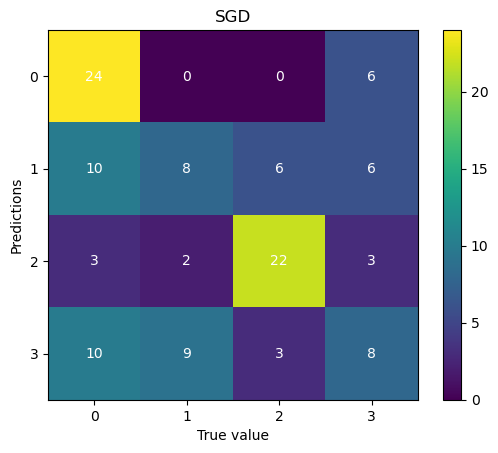

In [ ]:
labels = np.unique(true_value)
cm3 = confusion_matrix(true_value, pred_value)

im3 = plt.imshow(cm3)
labels1=range(0,10)

# Show all ticks and label them with the respective list entries
plt.xticks(labels)
plt.yticks(labels)

# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")

#Loop over data dimensions and create text annotations.
for i in range(len(labels)):
    for j in range(len(labels)):
        text = plt.text(j, i, cm3[i, j],
                       ha="center", va="center", color="w")

#cbar = ax[1,1].figure.colorbar(im4, ax=ax[1,1])
#cbar.ax.set_ylabel(labels, rotation=-90, va="bottom")


plt.title(f"{optimizer}")
#fig.set_figheight(10)
#fig.set_figwidth(20)
plt.xlabel("True value")
plt.ylabel("Predictions")
#fig.tight_layout()

#cbar_ax = fig.add_axes([0.95, 0.25, 0.02, 0.4])
plt.colorbar()
plt.savefig(f'{optimizer}_confusion', bbox_inches='tight')
#cm1 = confusion_matrix(true_value3, pred_value3)
print(classification_report(true_value, pred_value))

In [ ]:
#labels1 = np.array(np.unique(str(true_value1)))
#cm1 = confusion_matrix(true_value1, pred_value1)
#labels2 = np.unique(true_value2)
#cm2 = confusion_matrix(true_value2, pred_value2)
labels3 = np.unique(true_value3)
cm3 = confusion_matrix(true_value3, pred_value3)
#labels4 = np.unique(true_value4)
#cm4 = confusion_matrix(true_value4, pred_value4)
#labels5 = np.unique(true_value5)
#cm5 = confusion_matrix(true_value5, pred_value5)
#labels6 = np.unique(true_value6)
#cm6 = confusion_matrix(true_value6, pred_value6)

NameError: name 'accu1' is not defined

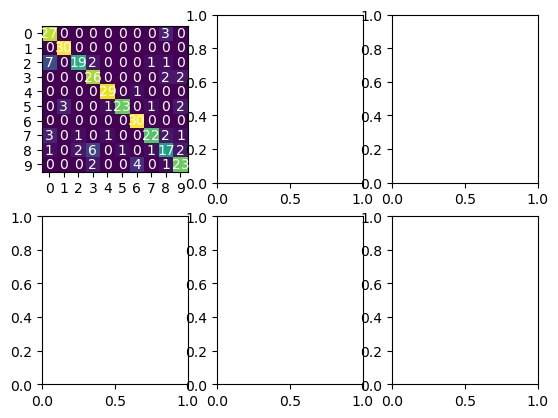

In [ ]:
fig, ax = plt.subplots(2, 3)#, sharex=True, sharey=True)
im1 = ax[0,0].imshow(cm1)

# Show all ticks and label them with the respective list entries
ax[0,0].set_xticks(np.arange(len(labels1)), labels=labels1)
ax[0,0].set_yticks(np.arange(len(labels1)), labels=labels1)

# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")

#Loop over data dimensions and create text annotations.
for i in range(len(labels1)):
    for j in range(len(labels1)):
        text = ax[0,0].text(j, i, cm1[i, j],
                       ha="center", va="center", color="w")

#cbar = ax[0,0].figure.colorbar(im1, ax=ax[0,0])
#cbar.ax.set_ylabel(labels, rotation=-90, va="bottom")

ax[0,0].set_title(f"Curr:01, {accu1*100:.2f}%")
#ax.set_xlabel("True value")
#ax.set_ylabel("Predictions")

im2 = ax[0,1].imshow(cm2)

# Show all ticks and label them with the respective list entries
ax[0,1].set_xticks(np.arange(len(labels2)), labels=labels2)
ax[0,1].set_yticks(np.arange(len(labels2)), labels=labels2)

# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")

#Loop over data dimensions and create text annotations.
for i in range(len(labels2)):
    for j in range(len(labels2)):
        text = ax[0,1].text(j, i, cm2[i, j],
                       ha="center", va="center", color="w")

#cbar = ax[0,1].figure.colorbar(im2, ax=ax[0,1])
#cbar.ax.set_ylabel(labels, rotation=-90, va="bottom")

ax[0,1].set_title(f"Curr:02, {accu2*100:.2f}%")
#ax.set_xlabel("True value")
#ax.set_ylabel("Predictions")


im3 = ax[0,2].imshow(cm3)

# Show all ticks and label them with the respective list entries
ax[0,2].set_xticks(np.arange(len(labels3)), labels=labels3)
ax[0,2].set_yticks(np.arange(len(labels3)), labels=labels3)

# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")

#Loop over data dimensions and create text annotations.
for i in range(len(labels3)):
    for j in range(len(labels3)):
        text = ax[0,2].text(j, i, cm3[i, j],
                       ha="center", va="center", color="w")

#cbar = ax[1,0].figure.colorbar(im3, ax=ax[1,0])
#cbar.ax.set_ylabel(labels, rotation=-90, va="bottom")

ax[0,2].set_title(f"Curr:03, {accu3*100:.2f}%")
#ax.set_xlabel("True value")
#ax.set_ylabel("Predictions")


im4 = ax[1,0].imshow(cm4)

# Show all ticks and label them with the respective list entries
ax[1,0].set_xticks(np.arange(len(labels4)), labels=labels4)
ax[1,0].set_yticks(np.arange(len(labels4)), labels=labels4)

# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")

#Loop over data dimensions and create text annotations.
for i in range(len(labels4)):
    for j in range(len(labels4)):
        text = ax[1,0].text(j, i, cm4[i, j],
                       ha="center", va="center", color="w")

ax[1,0].set_title(f"Curr:04, {accu4*100:.2f}%")
#cbar = ax[1,1].figure.colorbar(im4, ax=ax[1,1])
#cbar.ax.set_ylabel(labels, rotation=-90, va="bottom")

im5 = ax[1,1].imshow(cm5)

# Show all ticks and label them with the respective list entries
ax[1,1].set_xticks(np.arange(len(labels5)), labels=labels5)
ax[1,1].set_yticks(np.arange(len(labels5)), labels=labels5)

# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")

#Loop over data dimensions and create text annotations.
for i in range(len(labels5)):
    for j in range(len(labels5)):
        text = ax[1,1].text(j, i, cm5[i, j],
                       ha="center", va="center", color="w")

#cbar = ax[1,1].figure.colorbar(im4, ax=ax[1,1])
#cbar.ax.set_ylabel(labels, rotation=-90, va="bottom")


ax[1,1].set_title(f"Curr:05, {accu5*100:.2f}%")

im6 = ax[1,2].imshow(cm6)

# Show all ticks and label them with the respective list entries
ax[1,2].set_xticks(np.arange(len(labels6)), labels=labels6)
ax[1,2].set_yticks(np.arange(len(labels6)), labels=labels6)

# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")

#Loop over data dimensions and create text annotations.
for i in range(len(labels6)):
    for j in range(len(labels6)):
        text = ax[1,2].text(j, i, cm6[i, j],
                       ha="center", va="center", color="w")

#cbar = ax[1,1].figure.colorbar(im4, ax=ax[1,1])
#cbar.ax.set_ylabel(labels, rotation=-90, va="bottom")


ax[1,2].set_title(f"Curr:06, {accu6*100:.2f}%")
fig.set_figheight(10)
fig.set_figwidth(20)
ax.set_xlabel("True value")
#ax.set_ylabel("Predictions")
#fig.tight_layout()

cbar_ax = fig.add_axes([0.95, 0.25, 0.02, 0.4])
fig.colorbar(im1, cax=cbar_ax)
fig.suptitle(f"Confusion Matrix, Optimizer: {optimizer}", fontsize=16)

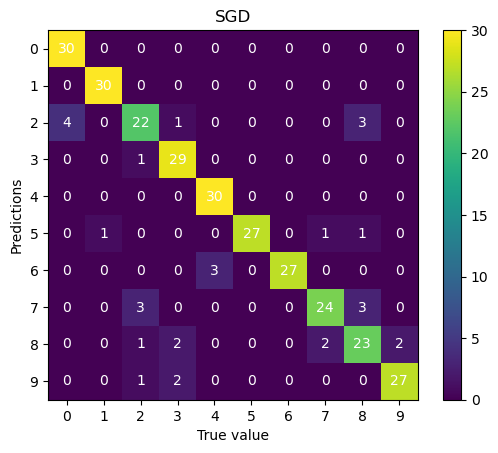

In [ ]:
im3 = plt.imshow(cm3)
labels1=range(0,10)

# Show all ticks and label them with the respective list entries
plt.xticks(labels1)
plt.yticks(labels1)

# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")

#Loop over data dimensions and create text annotations.
for i in range(len(labels1)):
    for j in range(len(labels1)):
        text = plt.text(j, i, cm3[i, j],
                       ha="center", va="center", color="w")

#cbar = ax[1,1].figure.colorbar(im4, ax=ax[1,1])
#cbar.ax.set_ylabel(labels, rotation=-90, va="bottom")


plt.title(f"{optimizer}")
#fig.set_figheight(10)
#fig.set_figwidth(20)
plt.xlabel("True value")
plt.ylabel("Predictions")
#fig.tight_layout()

#cbar_ax = fig.add_axes([0.95, 0.25, 0.02, 0.4])
plt.colorbar()
plt.savefig(f'{optimizer}_confusion', bbox_inches='tight')

In [ ]:
cm1 = confusion_matrix(true_value3, pred_value3)
print(classification_report(true_value3, pred_value3))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        30
           1       0.97      1.00      0.98        30
           2       0.79      0.73      0.76        30
           3       0.85      0.97      0.91        30
           4       0.91      1.00      0.95        30
           5       1.00      0.90      0.95        30
           6       1.00      0.90      0.95        30
           7       0.89      0.80      0.84        30
           8       0.77      0.77      0.77        30
           9       0.93      0.90      0.92        30

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300



Text(0.5, 0.98, 'Confusion Matrix, Optimizer: Adam')

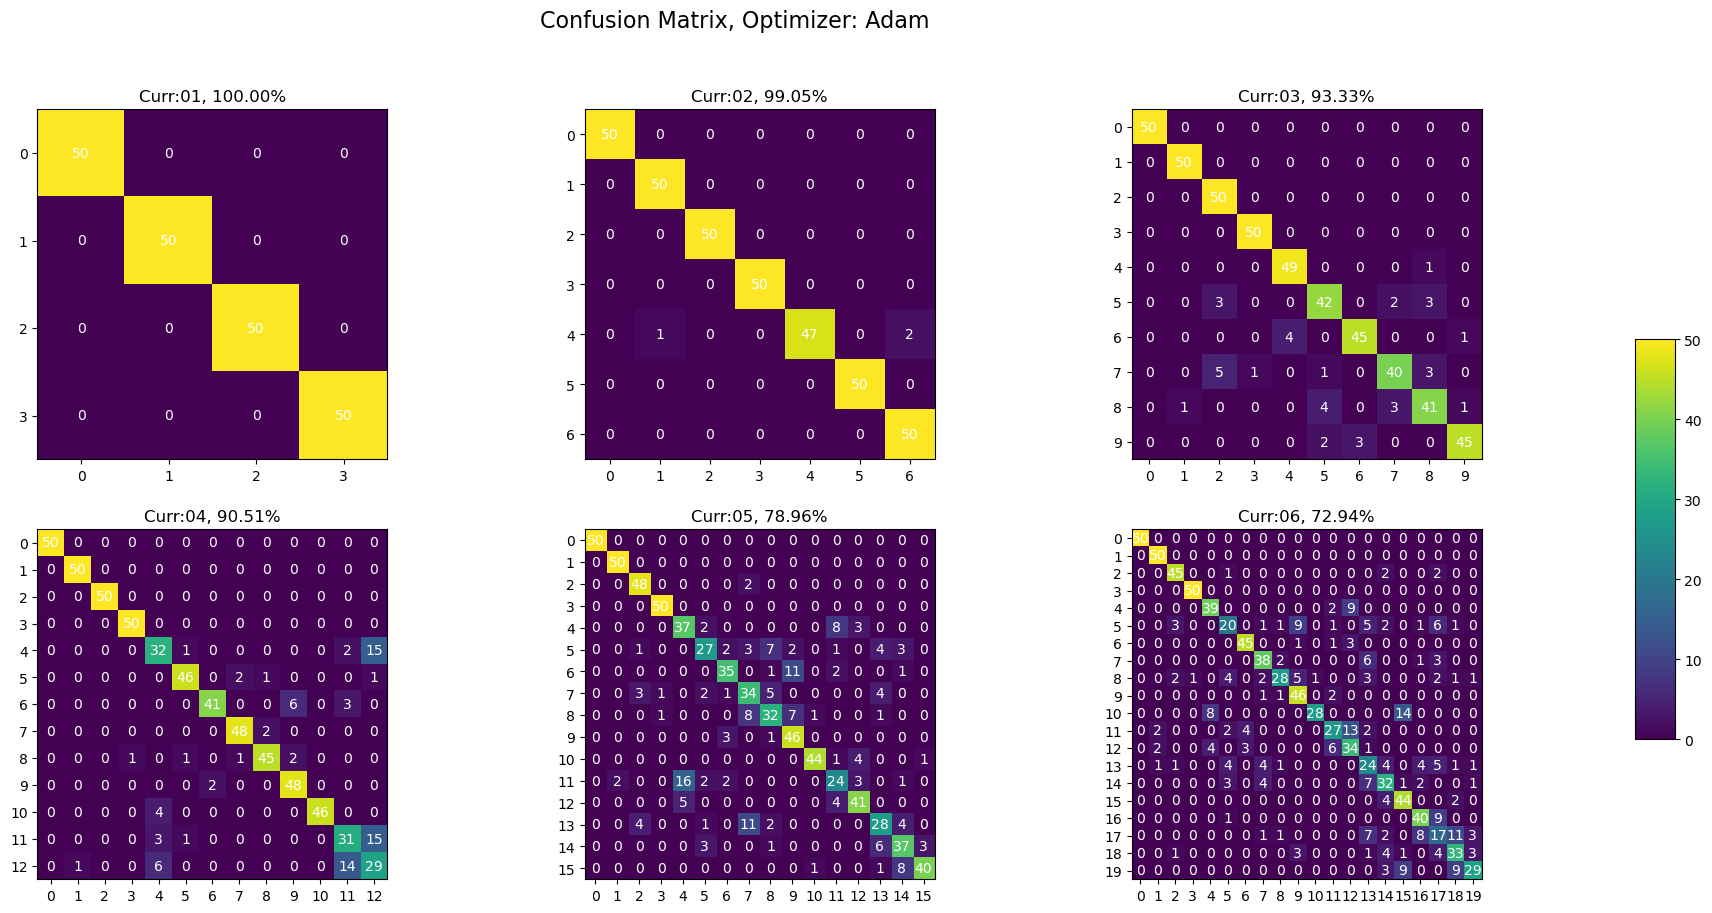

In [ ]:
optimizer = "Adam"
pred_value1, true_value1, accu1 = validation(valid_dataloader1, model, f'{optimizer}_200_200_curr01_full')
pred_value2, true_value2, accu2 = validation(valid_dataloader2, model, f'{optimizer}_200_200_curr02_full')
pred_value3, true_value3, accu3 = validation(valid_dataloader3, model, f'{optimizer}_200_200_curr03_full')
pred_value4, true_value4, accu4 = validation(valid_dataloader4, model, f'{optimizer}_200_200_curr04_full')
pred_value5, true_value5, accu5 = validation(valid_dataloader5, model, f'{optimizer}_200_200_curr05_full')
pred_value6, true_value6, accu6 = validation(valid_dataloader6, model, f'{optimizer}_200_200_curr06_full')

labels1 = np.unique(true_value1)
cm1 = confusion_matrix(true_value1, pred_value1, labels=labels1)
labels2 = np.unique(true_value2)
cm2 = confusion_matrix(true_value2, pred_value2, labels=labels2)
labels3 = np.unique(true_value3)
cm3 = confusion_matrix(true_value3, pred_value3, labels=labels3)
labels4 = np.unique(true_value4)
cm4 = confusion_matrix(true_value4, pred_value4, labels=labels4)
labels5 = np.unique(true_value5)
cm5 = confusion_matrix(true_value5, pred_value5, labels=labels5)
labels6 = np.unique(true_value6)
cm6 = confusion_matrix(true_value6, pred_value6, labels=labels6)

fig, ax = plt.subplots(2, 3)#, sharex=True, sharey=True)
im1 = ax[0,0].imshow(cm1)

# Show all ticks and label them with the respective list entries
ax[0,0].set_xticks(np.arange(len(labels1)), labels=labels1)
ax[0,0].set_yticks(np.arange(len(labels1)), labels=labels1)

# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")

#Loop over data dimensions and create text annotations.
for i in range(len(labels1)):
    for j in range(len(labels1)):
        text = ax[0,0].text(j, i, cm1[i, j],
                       ha="center", va="center", color="w")

#cbar = ax[0,0].figure.colorbar(im1, ax=ax[0,0])
#cbar.ax.set_ylabel(labels, rotation=-90, va="bottom")

ax[0,0].set_title(f"Curr:01, {accu1*100:.2f}%")
#ax.set_xlabel("True value")
#ax.set_ylabel("Predictions")

im2 = ax[0,1].imshow(cm2)

# Show all ticks and label them with the respective list entries
ax[0,1].set_xticks(np.arange(len(labels2)), labels=labels2)
ax[0,1].set_yticks(np.arange(len(labels2)), labels=labels2)

# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")

#Loop over data dimensions and create text annotations.
for i in range(len(labels2)):
    for j in range(len(labels2)):
        text = ax[0,1].text(j, i, cm2[i, j],
                       ha="center", va="center", color="w")

#cbar = ax[0,1].figure.colorbar(im2, ax=ax[0,1])
#cbar.ax.set_ylabel(labels, rotation=-90, va="bottom")

ax[0,1].set_title(f"Curr:02, {accu2*100:.2f}%")
#ax.set_xlabel("True value")
#ax.set_ylabel("Predictions")


im3 = ax[0,2].imshow(cm3)

# Show all ticks and label them with the respective list entries
ax[0,2].set_xticks(np.arange(len(labels3)), labels=labels3)
ax[0,2].set_yticks(np.arange(len(labels3)), labels=labels3)

# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")

#Loop over data dimensions and create text annotations.
for i in range(len(labels3)):
    for j in range(len(labels3)):
        text = ax[0,2].text(j, i, cm3[i, j],
                       ha="center", va="center", color="w")

#cbar = ax[1,0].figure.colorbar(im3, ax=ax[1,0])
#cbar.ax.set_ylabel(labels, rotation=-90, va="bottom")

ax[0,2].set_title(f"Curr:03, {accu3*100:.2f}%")
#ax.set_xlabel("True value")
#ax.set_ylabel("Predictions")


im4 = ax[1,0].imshow(cm4)

# Show all ticks and label them with the respective list entries
ax[1,0].set_xticks(np.arange(len(labels4)), labels=labels4)
ax[1,0].set_yticks(np.arange(len(labels4)), labels=labels4)

# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")

#Loop over data dimensions and create text annotations.
for i in range(len(labels4)):
    for j in range(len(labels4)):
        text = ax[1,0].text(j, i, cm4[i, j],
                       ha="center", va="center", color="w")

ax[1,0].set_title(f"Curr:04, {accu4*100:.2f}%")
#cbar = ax[1,1].figure.colorbar(im4, ax=ax[1,1])
#cbar.ax.set_ylabel(labels, rotation=-90, va="bottom")

im5 = ax[1,1].imshow(cm5)

# Show all ticks and label them with the respective list entries
ax[1,1].set_xticks(np.arange(len(labels5)), labels=labels5)
ax[1,1].set_yticks(np.arange(len(labels5)), labels=labels5)

# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")

#Loop over data dimensions and create text annotations.
for i in range(len(labels5)):
    for j in range(len(labels5)):
        text = ax[1,1].text(j, i, cm5[i, j],
                       ha="center", va="center", color="w")

#cbar = ax[1,1].figure.colorbar(im4, ax=ax[1,1])
#cbar.ax.set_ylabel(labels, rotation=-90, va="bottom")


ax[1,1].set_title(f"Curr:05, {accu5*100:.2f}%")

im6 = ax[1,2].imshow(cm6)

# Show all ticks and label them with the respective list entries
ax[1,2].set_xticks(np.arange(len(labels6)), labels=labels6)
ax[1,2].set_yticks(np.arange(len(labels6)), labels=labels6)

# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")

#Loop over data dimensions and create text annotations.
for i in range(len(labels6)):
    for j in range(len(labels6)):
        text = ax[1,2].text(j, i, cm6[i, j],
                       ha="center", va="center", color="w")

#cbar = ax[1,1].figure.colorbar(im4, ax=ax[1,1])
#cbar.ax.set_ylabel(labels, rotation=-90, va="bottom")


ax[1,2].set_title(f"Curr:06, {accu6*100:.2f}%")
fig.set_figheight(10)
fig.set_figwidth(20)
#ax.set_xlabel("True value")
#ax.set_ylabel("Predictions")
#fig.tight_layout()

cbar_ax = fig.add_axes([0.95, 0.25, 0.02, 0.4])
fig.colorbar(im1, cax=cbar_ax)
fig.suptitle(f"Confusion Matrix, Optimizer: {optimizer}", fontsize=16)

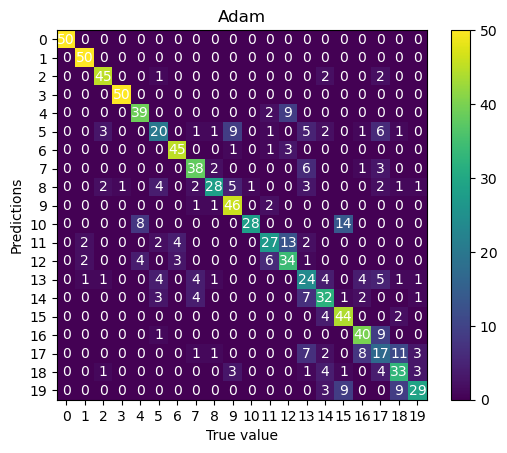

In [ ]:
im6 = plt.imshow(cm6)

# Show all ticks and label them with the respective list entries
plt.xticks(np.arange(len(labels6)), labels=labels6)
plt.yticks(np.arange(len(labels6)), labels=labels6)

# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")

#Loop over data dimensions and create text annotations.
for i in range(len(labels6)):
    for j in range(len(labels6)):
        text = plt.text(j, i, cm6[i, j],
                       ha="center", va="center", color="w")

#cbar = ax[1,1].figure.colorbar(im4, ax=ax[1,1])
#cbar.ax.set_ylabel(labels, rotation=-90, va="bottom")


plt.title(f"{optimizer}")
#fig.set_figheight(10)
#fig.set_figwidth(20)
plt.xlabel("True value")
plt.ylabel("Predictions")
#fig.tight_layout()

cbar_ax = fig.add_axes([0.95, 0.25, 0.02, 0.4])
plt.colorbar()
plt.savefig(f'{optimizer}_confusion', bbox_inches='tight')

In [ ]:
cm6 = confusion_matrix(true_value6, pred_value6)
print(classification_report(true_value6, pred_value6))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.91      1.00      0.95        50
           2       0.87      0.90      0.88        50
           3       0.98      1.00      0.99        50
           4       0.76      0.78      0.77        50
           5       0.57      0.40      0.47        50
           6       0.87      0.90      0.88        50
           7       0.75      0.76      0.75        50
           8       0.82      0.56      0.67        50
           9       0.72      0.92      0.81        50
          10       0.97      0.56      0.71        50
          11       0.69      0.54      0.61        50
          12       0.58      0.68      0.62        50
          13       0.43      0.48      0.45        50
          14       0.60      0.64      0.62        50
          15       0.64      0.88      0.74        50
          16       0.71      0.80      0.75        50
          17       0.35    

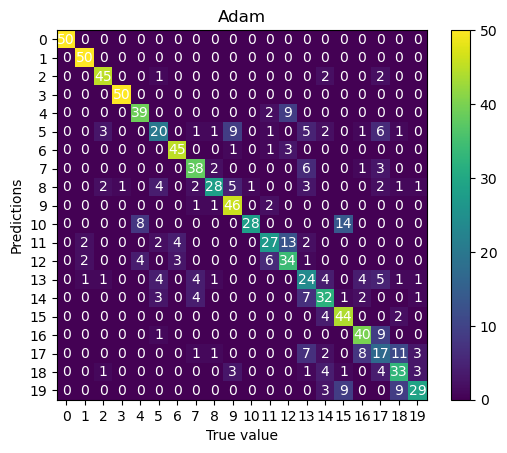

In [ ]:
optimizer = "Adam"
pred_value1, true_value1, accu1 = validation(valid_dataloader1, model, f'{optimizer}_200_200_curr01_full')
pred_value2, true_value2, accu2 = validation(valid_dataloader2, model, f'{optimizer}_200_200_curr02_full')
pred_value3, true_value3, accu3 = validation(valid_dataloader3, model, f'{optimizer}_200_200_curr03_full')
pred_value4, true_value4, accu4 = validation(valid_dataloader4, model, f'{optimizer}_200_200_curr04_full')
pred_value5, true_value5, accu5 = validation(valid_dataloader5, model, f'{optimizer}_200_200_curr05_full')
pred_value6, true_value6, accu6 = validation(valid_dataloader6, model, f'{optimizer}_200_200_curr06_full')

labels1 = np.unique(true_value1)
cm1 = confusion_matrix(true_value1, pred_value1, labels=labels1)
labels2 = np.unique(true_value2)
cm2 = confusion_matrix(true_value2, pred_value2, labels=labels2)
labels3 = np.unique(true_value3)
cm3 = confusion_matrix(true_value3, pred_value3, labels=labels3)
labels4 = np.unique(true_value4)
cm4 = confusion_matrix(true_value4, pred_value4, labels=labels4)
labels5 = np.unique(true_value5)
cm5 = confusion_matrix(true_value5, pred_value5, labels=labels5)
labels6 = np.unique(true_value6)
cm6 = confusion_matrix(true_value6, pred_value6, labels=labels6)

im6 = plt.imshow(cm6)

# Show all ticks and label them with the respective list entries
plt.xticks(np.arange(len(labels6)), labels=labels6)
plt.yticks(np.arange(len(labels6)), labels=labels6)

# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")

#Loop over data dimensions and create text annotations.
for i in range(len(labels6)):
    for j in range(len(labels6)):
        text = plt.text(j, i, cm6[i, j],
                       ha="center", va="center", color="w")

#cbar = ax[1,1].figure.colorbar(im4, ax=ax[1,1])
#cbar.ax.set_ylabel(labels, rotation=-90, va="bottom")


plt.title(f"{optimizer}")
#fig.set_figheight(10)
#fig.set_figwidth(20)
plt.xlabel("True value")
plt.ylabel("Predictions")
#fig.tight_layout()

cbar_ax = fig.add_axes([0.95, 0.25, 0.02, 0.4])
plt.colorbar()
plt.savefig(f'{optimizer}_confusion', bbox_inches='tight')

In [ ]:
print(classification_report(true_value6, pred_value6))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.91      1.00      0.95        50
           2       0.87      0.90      0.88        50
           3       0.98      1.00      0.99        50
           4       0.76      0.78      0.77        50
           5       0.57      0.40      0.47        50
           6       0.87      0.90      0.88        50
           7       0.75      0.76      0.75        50
           8       0.82      0.56      0.67        50
           9       0.72      0.92      0.81        50
          10       0.97      0.56      0.71        50
          11       0.69      0.54      0.61        50
          12       0.58      0.68      0.62        50
          13       0.43      0.48      0.45        50
          14       0.60      0.64      0.62        50
          15       0.64      0.88      0.74        50
          16       0.71      0.80      0.75        50
          17       0.35    